# Pyroomacoustics Demo

### dependencies:  pyroomacoustics, pysoundfile, samplerate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import soundfile

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

%matplotlib inline

import librosa
import librosa.display
import samplerate

import IPython.display as ipd

from scipy import signal

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

import pandas as pd

%load_ext autoreload
%autoreload 2
from doa_lib import *

## Read file and show it in spectogram 

In [46]:
file_name = '../recordings/180910_142834.wav'
signal_times=[[69.9, 70.6], [110.8, 111.7], [155.8, 156.7], [285.7, 286.3]]
algo_name = 'MUSIC'
hot_sig = 0

ang_error = dict()

for y_loc in range(2,9):
    room_dim = [10000, 10, 10000]
    r_source=np.c_[[5005, y_loc, 5000]]
    r_rec=np.c_[
        [5000, 4.5, 5000],  # mic 1
        [5000, 5.5, 5000],  # mic 2
        ]
    
    rx_center = r_rec.mean(axis=1, keepdims=True)
    v = r_source-rx_center
    base_vec = np.c_[[1,0,0]]
    c = np.dot(v.T, base_vec)/np.linalg.norm(base_vec)/np.linalg.norm(v) # -> cosine of the angle
    angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle
    azimuth = [np.mod(2*np.pi+np.sign(v[1])[0]*angle[0,0],2*np.pi)]

    # reshape into 1d numpy array
    r_source = r_source[:,0]
    
    ang_error[y_loc] = []
    
    for times in signal_times:
        data, fs = read_sound(file_name, time=times)

        rec_signal = sim_room(data, fs, absorption=0.6, r_source=r_source, r_rec=r_rec, room_dim=room_dim)

        for noise_ind in range(4): 
            rec_signal_noised = add_noise(rec_signal, SNR=10, noise_id=(noise_ind,noise_ind+1),
                                          noise_location_doc='silence_180910_142834.txt')

            if hot_sig:
                clim = (-70,-20)
                spect(data/np.sqrt(np.sum(data**2)), fs, figsize=[20,5])
                plt.colorbar()
                plt.clim(clim)

                spect(rec_signal_noised[0,:], fs, figsize=[20,5])
                plt.colorbar()
                plt.clim(clim)

                spect(rec_signal_noised[1,:], fs, figsize=[20,5])
                plt.colorbar()
                plt.clim(clim)
                hot_sig = 0

            nfft = 1024*8
            overlap_ratio = 1
            X = np.array([produce_spect_for_music(channel_sig, nfft=nfft, overlap_ratio=overlap_ratio, fft_type='stft')
                          for channel_sig in rec_signal_noised])

            doa = locate_source(X[:, :, :], r_rec, fs, nfft, algo_name, freq_range = [300., 800.])
#             plot_doa(doa, azimuth, algo_name)
            
            angle_grid = doa.grid.azimuth*180/np.pi
            doa_values = doa.grid.values
            
            ind_select = (angle_grid<90) | (angle_grid>270)
            
            select_angle = angle_grid[ind_select][np.argmax(doa_values[ind_select])]
            
            error_angle = np.abs(select_angle-azimuth[0]*180/np.pi)
            
            ang_error[y_loc].append(error_angle)

#             raise(Exception('stop'))

In [51]:
ang_error

{2: [4.963756532073489,
  4.963756532073489,
  4.963756532073489,
  4.963756532073489,
  2.036243467926454,
  2.036243467926454,
  2.036243467926454,
  2.036243467926454,
  9.963756532073546,
  9.963756532073546,
  9.963756532073546,
  9.963756532073546,
  0.9637565320734893,
  0.9637565320734893,
  0.9637565320734893,
  0.9637565320734893],
 3: [5.198590513648185,
  5.198590513648185,
  5.198590513648185,
  5.198590513648185,
  10.198590513648185,
  10.198590513648185,
  10.198590513648185,
  10.198590513648185,
  1.8014094863518153,
  1.8014094863518153,
  1.8014094863518153,
  1.8014094863518153,
  0.8014094863518153,
  0.8014094863518153,
  0.8014094863518153,
  0.8014094863518153],
 4: [4.690067525979714,
  4.690067525979714,
  4.690067525979714,
  4.690067525979714,
  10.69006752597977,
  10.69006752597977,
  10.69006752597977,
  10.69006752597977,
  9.69006752597977,
  9.69006752597977,
  9.69006752597977,
  9.69006752597977,
  346.69006752597977,
  346.69006752597977,
  346.690

In [68]:
np.concatenate((error_list.reshape(-1,1), error_list_fliped.reshape(-1,1)), axis=1)

array([[  4.96375653, 355.03624347],
       [  4.96375653, 355.03624347],
       [  4.96375653, 355.03624347],
       [  4.96375653, 355.03624347],
       [  2.03624347, 357.96375653],
       [  2.03624347, 357.96375653],
       [  2.03624347, 357.96375653],
       [  2.03624347, 357.96375653],
       [  9.96375653, 350.03624347],
       [  9.96375653, 350.03624347],
       [  9.96375653, 350.03624347],
       [  9.96375653, 350.03624347],
       [  0.96375653, 359.03624347],
       [  0.96375653, 359.03624347],
       [  0.96375653, 359.03624347],
       [  0.96375653, 359.03624347]])

In [69]:
for s_depth in ang_error.keys():
    error_list = np.array(ang_error[s_depth])
    error_list_fliped = 360-error_list
    error_list = np.min(np.concatenate((error_list.reshape(-1,1), error_list_fliped.reshape(-1,1)), axis=1), axis=1)
    
    print(s_depth, error_list.mean())

2 4.481878266036745
3 4.5
4 9.595033762989871
5 1.5
6 7.5
7 5.099295256824093
8 10.0


In [35]:
angle_grid = doa.grid.azimuth*180/np.pi
doa_values = doa.grid.values
            
ind_select = (angle_grid<90) | (angle_grid>270)


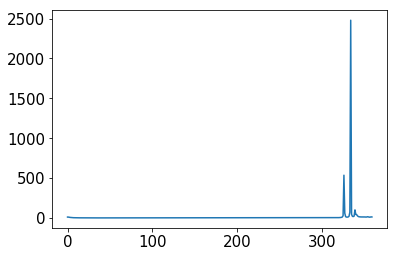

In [37]:
plt.plot(doa.grid.azimuth[ind_select]*180/np.pi,doa.grid.values[ind_select])
plt.show()

NameError: name 'rec_signal' is not defined

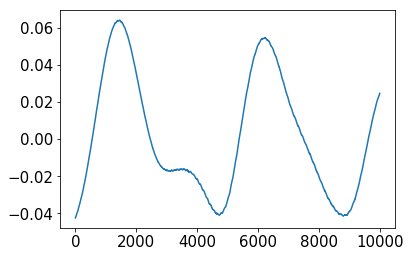

In [15]:
extent = 10000

plt.plot(data[:extent])
plt.plot(rec_signal[0,:extent])
plt.plot(rec_signal[1,:extent])
plt.plot(0*rec_signal[1,:extent])
plt.show()